In [1]:
import importlib
from pathlib import Path

import folium
import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skrub import TableReport

import utils as bc  # My personal module

# EDA from the original dataset

In [3]:
data = pd.read_parquet(Path("data") / "train.parquet").reset_index(drop=True)

In [3]:
TableReport(data)

Processing column  12 / 12


,,,,,,,,,,,,


##### Counter Locations in Paris

In [4]:
m = folium.Map(
    location=data[["latitude", "longitude"]].mean(axis=0),
    zoom_start=12,
    tiles="Cartodb Positron",
)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

c:\Users\lucie\anaconda3\envs\bikes-count\lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


##### fun fact: tour de france le 18 juillet 2021

In [13]:
date = "2021-07-18"
date_m1 = "2021-07-17"
date_p1 = "2021-07-19"
counter = "Pont de la Concorde S-N"
tour_de_france = data[
    (data["date"].astype(str).str.contains(date)) & (data["counter_name"] == counter)
]["bike_count"].sum()
day_before = data[
    (data["date"].astype(str).str.contains(date_m1)) & (data["counter_name"] == counter)
]["bike_count"].sum()
day_after = data[
    (data["date"].astype(str).str.contains(date_p1)) & (data["counter_name"] == counter)
]["bike_count"].sum()

print(day_before, tour_de_france, day_after)

1493.0 227.0 2309.0


### Time Series Analysis

In [28]:
data["bike_count"].mean()

np.float64(60.191475100990885)

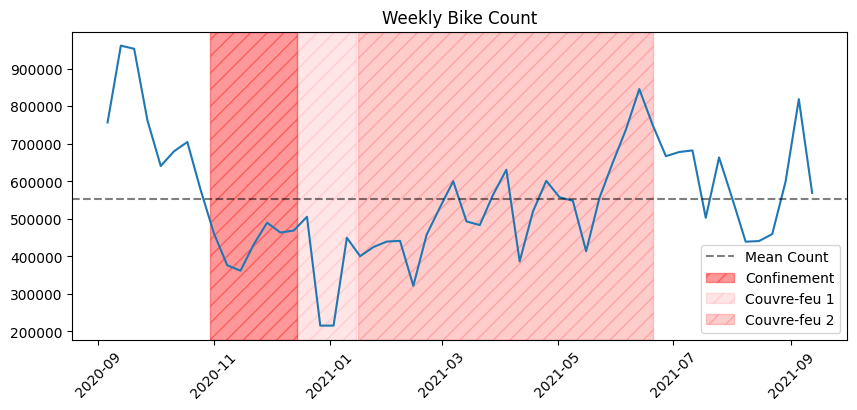

In [35]:
confinement_start = pd.Timestamp("2020-10-30")
confinement_end = pd.Timestamp("2020-12-15")
couvre_feu_1_start = pd.Timestamp("2020-12-15")
couvre_feu_1_end = pd.Timestamp("2021-01-15")
couvre_feu_2_start = pd.Timestamp("2021-01-16")
couvre_feu_2_end = pd.Timestamp("2021-06-20")

plt.figure(figsize=(10, 4))
plt.plot(data.groupby(pd.Grouper(freq="1W", key="date"))["bike_count"].sum())
plt.axhline(
    data.groupby(pd.Grouper(freq="1W", key="date"))["bike_count"].sum().mean(),
    color="black",
    linestyle="--",
    alpha=0.5,
    label="Mean Count",
)
plt.axvspan(
    confinement_start,
    confinement_end,
    color="red",
    alpha=0.4,
    hatch="//",
    label="Confinement",
)
plt.axvspan(
    couvre_feu_1_start,
    couvre_feu_1_end,
    color="red",
    alpha=0.1,
    hatch="//",
    label="Couvre-feu 1",
)
plt.axvspan(
    couvre_feu_2_start,
    couvre_feu_2_end,
    color="red",
    alpha=0.2,
    hatch="//",
    label="Couvre-feu 2",
)

plt.title("Weekly Bike Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [36]:
counters = data["counter_name"].drop_duplicates().values.tolist()


def plotting_counters(counter, start, end):

    global_counter_average = data[data["counter_name"] == counter]["bike_count"].mean()

    counter_data = data[
        (
            (data["counter_name"] == counter)
            & (data["date"] > pd.to_datetime(start))
            & (data["date"] < pd.to_datetime(end))
        )
    ].sort_values(by="date", ascending=False)

    plt.figure(figsize=(10, 4))

    plt.plot(counter_data["date"], counter_data["bike_count"])
    plt.title(f"{counter} average bike count between {start} and {end}")
    plt.axhline(
        global_counter_average,
        color="r",
        linestyle="--",
        alpha=0.7,
        label=f"{counter} Global Average Bike Count",
    )
    plt.axhline(
        counter_data["bike_count"].mean(),
        color="black",
        linestyle="--",
        alpha=0.7,
        label="Average for the period",
    )
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

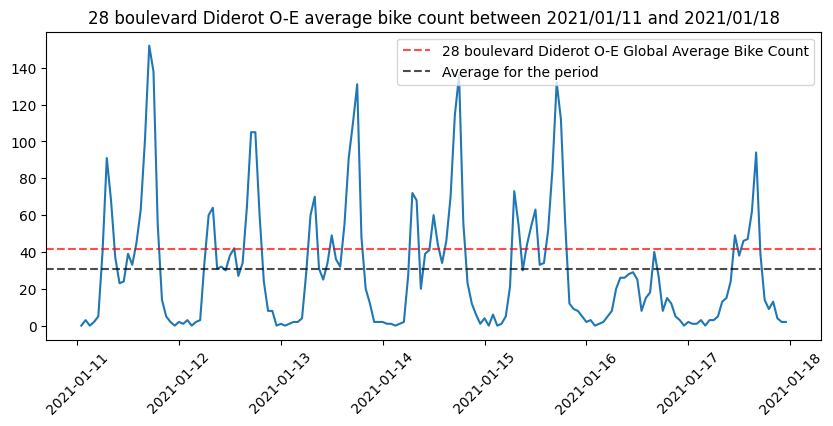

In [38]:
plotting_counters(counters[1], "2021/01/11", "2021/01/18")

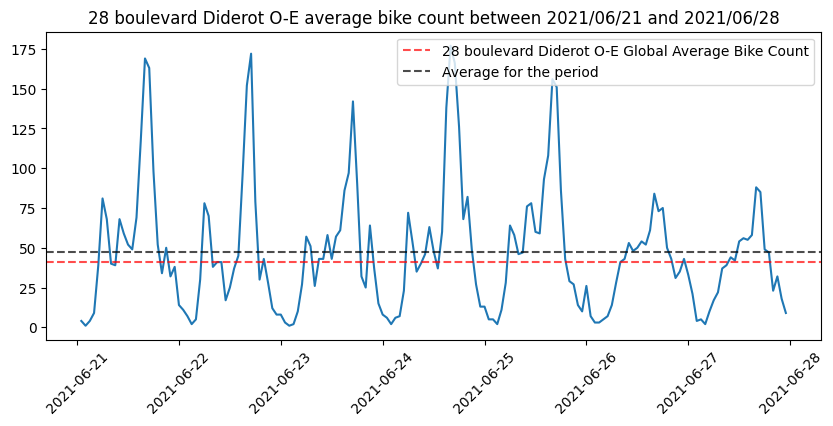

In [39]:
plotting_counters(counters[1], "2021/06/21", "2021/06/28")

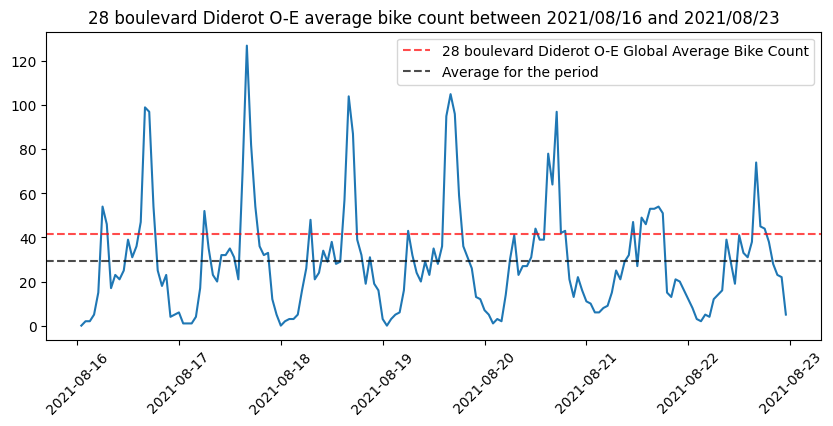

In [44]:
plotting_counters(counters[1], "2021/08/16", "2021/08/23")

We see a clear correlation between working days/hours and bike count in Paris. 

During colder times, we notice much less bikes passing through the same counters, and during summer we notice less bikes as well, surely because people are on vacation.

### Date Elements Analysis

In [26]:
def encode_date(X):
    X = X.copy()
    X["month_day"] = X["date"].dt.day
    X["week_day"] = X["date"].dt.day_of_week + 1
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["hour"] = X["date"].dt.hour
    X["is_weekend"] = (X["week_day"] >= 6).astype(int)
    years = X["year"].drop_duplicates().values.tolist()
    french_holidays = set(holidays.country_holidays("FR", years=years))
    X["is_holiday"] = X["date"].dt.date.isin(french_holidays).astype(int)
    X["covid_state"] = X["date"].apply(bc.covid_period)
    years = X["date"].dt.year.unique()
    holiday_dates = set()
    for year in years:
        holiday_dates.update(
            date
            for date, info in bc.SchoolHolidayDates()
            .holidays_for_year_and_zone(year, "C")
            .items()
        )
    X["is_school_holiday"] = X["date"].dt.date.isin(holiday_dates).astype(int)

    X = X.drop(columns=["date"])
    return X

In [27]:
date_data = pd.concat([encode_date(data[["date"]]), data[["bike_count"]]], axis=1)

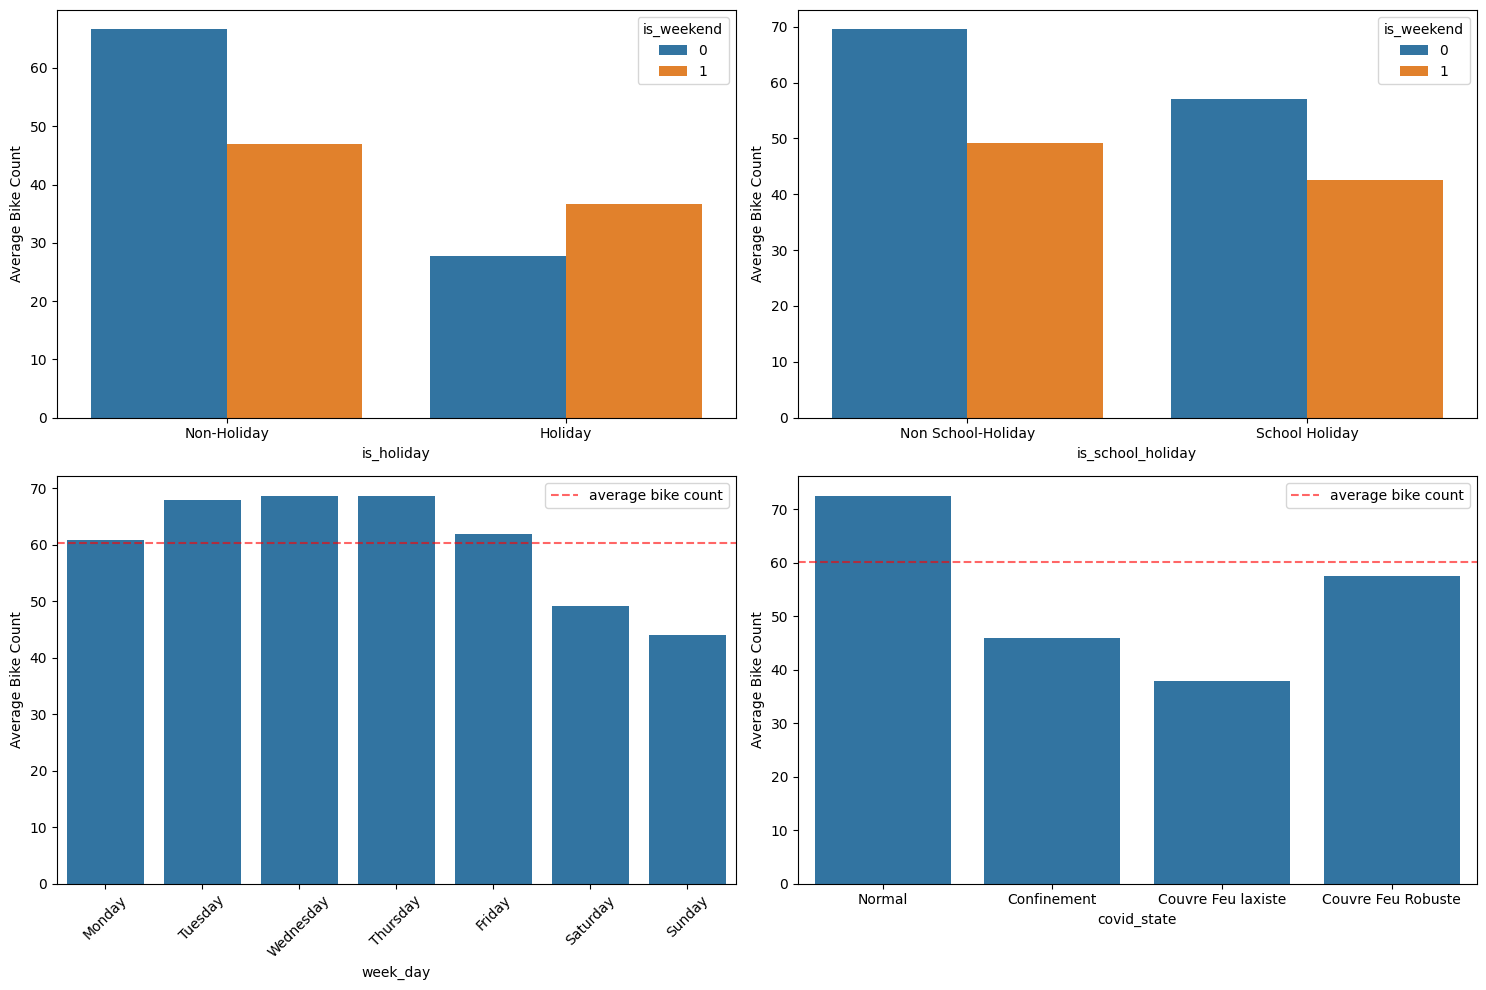

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.barplot(
    data=(
        date_data.groupby(["is_holiday", "is_weekend"])["bike_count"]
        .mean()
        .reset_index()
    ),
    x="is_holiday",
    y="bike_count",
    hue="is_weekend",
)

plt.ylabel("Average Bike Count")
plt.xticks([0, 1], ["Non-Holiday", "Holiday"])


plt.subplot(2, 2, 2)
sns.barplot(
    data=(
        date_data.groupby(["is_school_holiday", "is_weekend"])["bike_count"]
        .mean()
        .reset_index()
    ),
    x="is_school_holiday",
    y="bike_count",
    hue="is_weekend",
)

plt.ylabel("Average Bike Count")
plt.xticks([0, 1], ["Non School-Holiday", "School Holiday"])


plt.subplot(2, 2, 3)
sns.barplot(
    data=(date_data.groupby("week_day")["bike_count"].mean().reset_index()),
    x="week_day",
    y="bike_count",
)
plt.axhline(
    data["bike_count"].mean(),
    color="r",
    linestyle="--",
    alpha=0.6,
    label="average bike count",
)
plt.ylabel("Average Bike Count")
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
)
plt.xticks(rotation=45)
plt.legend()


plt.subplot(2, 2, 4)
sns.barplot(
    data=(date_data.groupby("covid_state")["bike_count"].mean().reset_index()),
    x="covid_state",
    y="bike_count",
)
plt.axhline(
    data["bike_count"].mean(),
    color="r",
    linestyle="--",
    alpha=0.6,
    label="average bike count",
)
plt.ylabel("Average Bike Count")
plt.legend()
plt.xticks(
    [0, 1, 2, 3], ["Normal", "Confinement", "Couvre Feu 20h-6h", "Couvre Feu 18h-6h"]
)


plt.tight_layout()
plt.show()

Less bikes when it's a french holiday or school holiday for zone C (includes Paris), and there are more bikes in the middle of the week. 

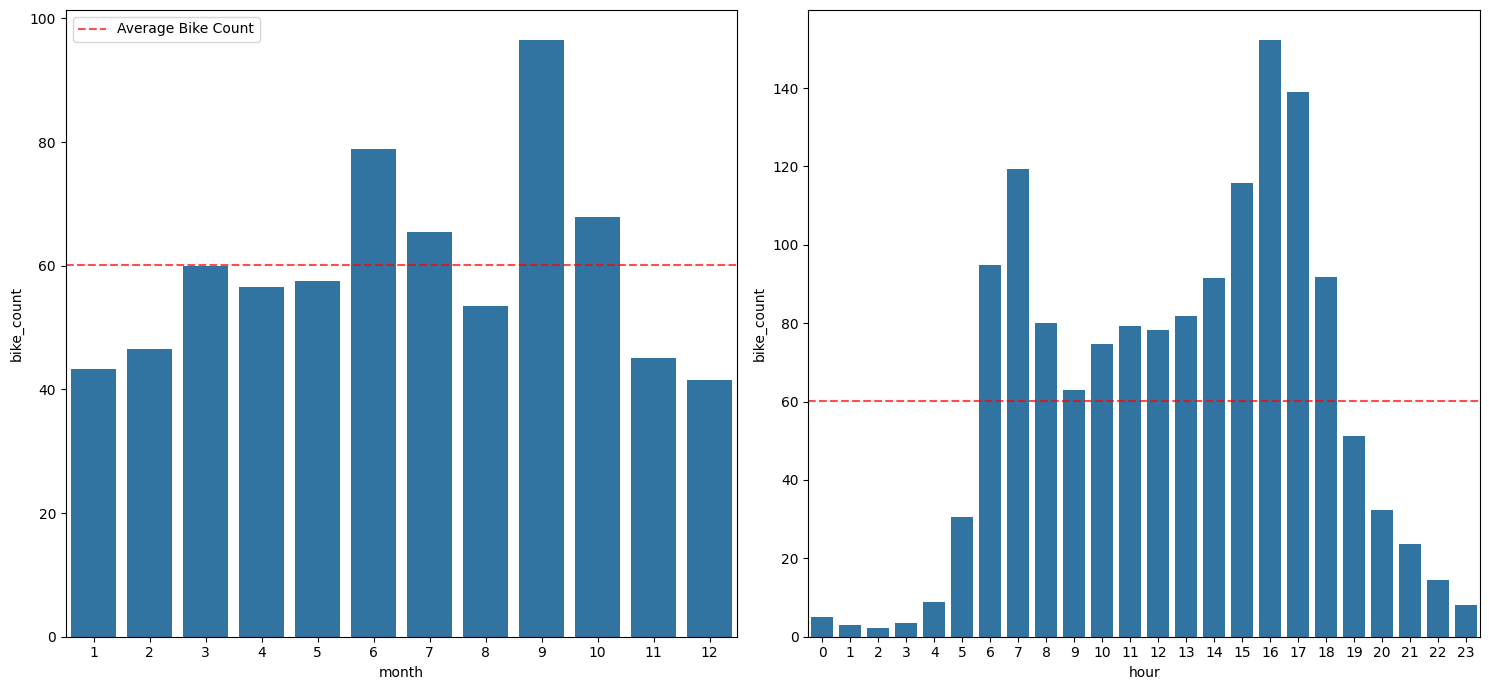

In [41]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(
    data=(date_data.groupby(["month"])["bike_count"].mean().reset_index()),
    x="month",
    y="bike_count",
)
plt.axhline(
    date_data["bike_count"].mean(),
    color="r",
    alpha=0.7,
    linestyle="--",
    label="Average Bike Count",
)
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(
    data=(date_data.groupby(["hour"])["bike_count"].mean().reset_index()),
    x="hour",
    y="bike_count",
)
plt.axhline(
    date_data["bike_count"].mean(),
    color="r",
    alpha=0.7,
    linestyle="--",
    label="Average Bike Count",
)
plt.tight_layout()
plt.show()

There are more bikes in Fall and Summer. Take a closer look at hourly trends per season

# EDA from meteorological dataset

### Cleaning

In [89]:
data = pd.read_csv("external_data/external_data.csv")
TableReport(data)

Processing column  59 / 59


<TableReport: use .open() to display>

In [90]:
# Dropping columns with 100% of null values and constant columns
null_columns = [
    "niv_bar",
    "geop",
    "tn24",
    "tx24",
    "sw",
    "tw",
    "phenspe1",
    "phenspe2",
    "phenspe3",
    "phenspe4",
    "numer_sta",
    "tminsol",
    "per",
]

data.drop(columns=null_columns, inplace=True)

In [91]:
numerical_data = data.select_dtypes(include=("int", "float"))
corr_matrix = numerical_data.corr()

high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs[0] > 0.8) & (high_corr_pairs[0] < 1.0)
]
high_corr_pairs.columns = ["Column 1", "Column 2", "Correlation"]
high_corr_pairs = high_corr_pairs[
    high_corr_pairs["Column 1"] < high_corr_pairs["Column 2"]
]
high_corr_pairs.sort_values("Correlation", ascending=False)

,Column 1,Column 2,Correlation
18,pmer,pres,0.999557
665,hbas,hnuage1,0.998314
202,ff,raf10,0.972878
1013,raf10,rafper,0.943663
246,t,tx12,0.941070
203,ff,rafper,0.923972
290,td,tn12,0.910196
245,t,tn12,0.898216
461,w1,w2,0.895852
921,tn12,tx12,0.892543


In [92]:
# Dropping highly correlated columns
correlated_columns = [
    "pmer",
    "hnuage1",
    "raf10",
    "tx12",
    "rafper",
    "tn12",
    "w2",
    "ch",
    "td",
]

In [93]:
external_columns_to_drop = null_columns + correlated_columns

### Link With Bike Count

In [97]:
def custom_merge_external_data(X):
    df_ext = pd.read_csv("external_data//external_data.csv", parse_dates=["date"])
    df_ext = df_ext.drop(columns=external_columns_to_drop)

    df_ext["date"] = pd.to_datetime(df_ext["date"]).astype("datetime64[us]")
    X = X.copy()
    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(
        X.sort_values("date"),
        df_ext.sort_values("date"),
        on="date",
        direction="nearest",
    )
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X


def custom_get_model_data(path="data/train.parquet"):
    data = pd.read_parquet(path)
    data.sort_values(["date", "counter_name"], inplace=True)
    y = data["log_bike_count"].values
    X = data
    return X, y

In [98]:
X, y = custom_get_model_data()
X = X[["date", "bike_count"]]
X = custom_merge_external_data(X)

In [96]:
corr = X.fillna(0).select_dtypes(include=["int64", "float64"]).corr()
bike_count_assoc = abs(corr.iloc[:, 0].sort_values(ascending=False)[1:])
bike_count_assoc.head(20).reset_index()

,index,bike_count
0,t,0.254320
1,ff,0.077014
2,hnuage2,0.067009
3,cod_tend,0.059478
4,vv,0.058932
5,pres,0.048892
6,hbas,0.047741
7,hnuage3,0.032367
8,cm,0.030398
9,hnuage4,0.025611


In [164]:
def get_hist(data, title):
    plt.hist(data, bins=30, color="blue", alpha=0.4)
    plt.title(title)


def get_scatter(data, title):
    plt.scatter(data, X["bike_count"])
    plt.ylabel("bike count")
    plt.xlabel(title)
    plt.axhline(400, color="r", alpha=0.7, linestyle="--")


def get_boxplot(data, title):
    plt.boxplot(data)
    plt.title(title)

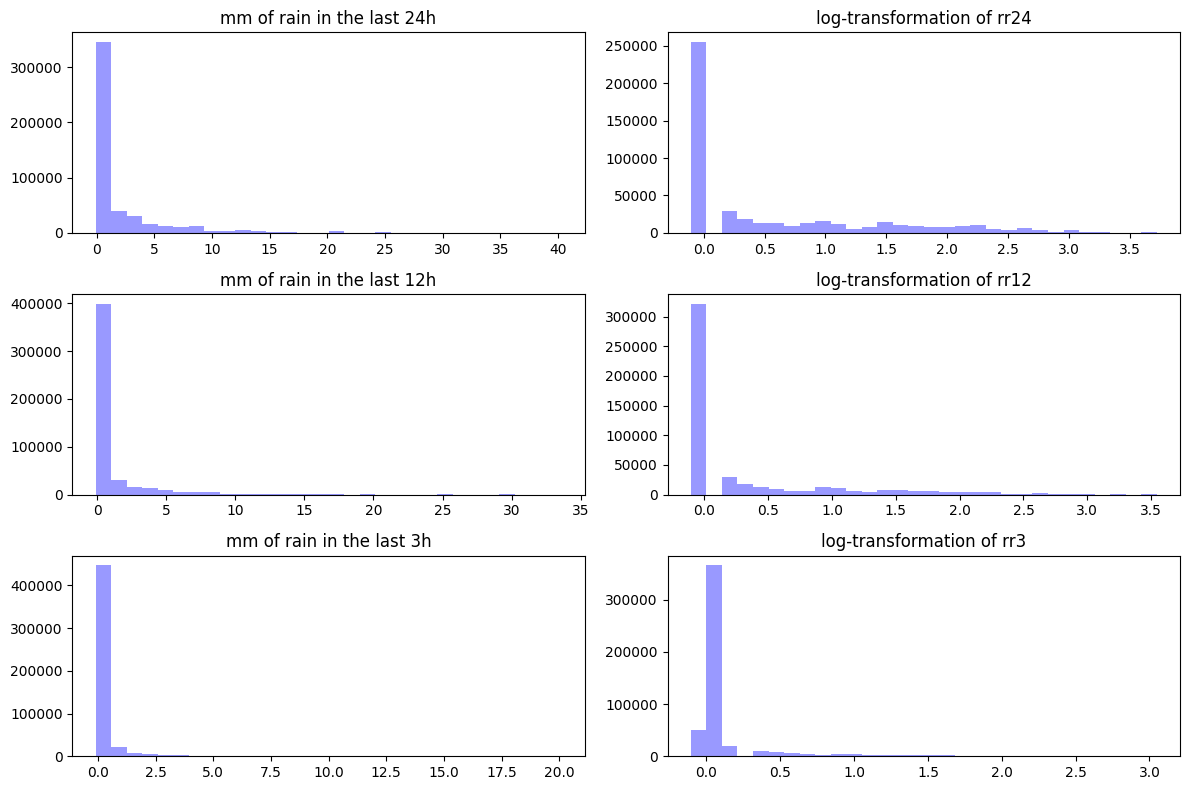

In [146]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
get_hist(X["rr24"], "mm of rain in the last 24h")

plt.subplot(3, 2, 2)
get_hist(np.log1p(X["rr24"]), "log-transformation of rr24")

plt.subplot(3, 2, 3)
get_hist(X["rr12"], "mm of rain in the last 12h")

plt.subplot(3, 2, 4)
get_hist(np.log1p(X["rr12"]), "log-transformation of rr12")

plt.subplot(3, 2, 5)
get_hist(X["rr3"], "mm of rain in the last 3h")

plt.subplot(3, 2, 6)
get_hist(np.log1p(X["rr3"]), "log-transformation of rr3")

plt.tight_layout()
plt.show()

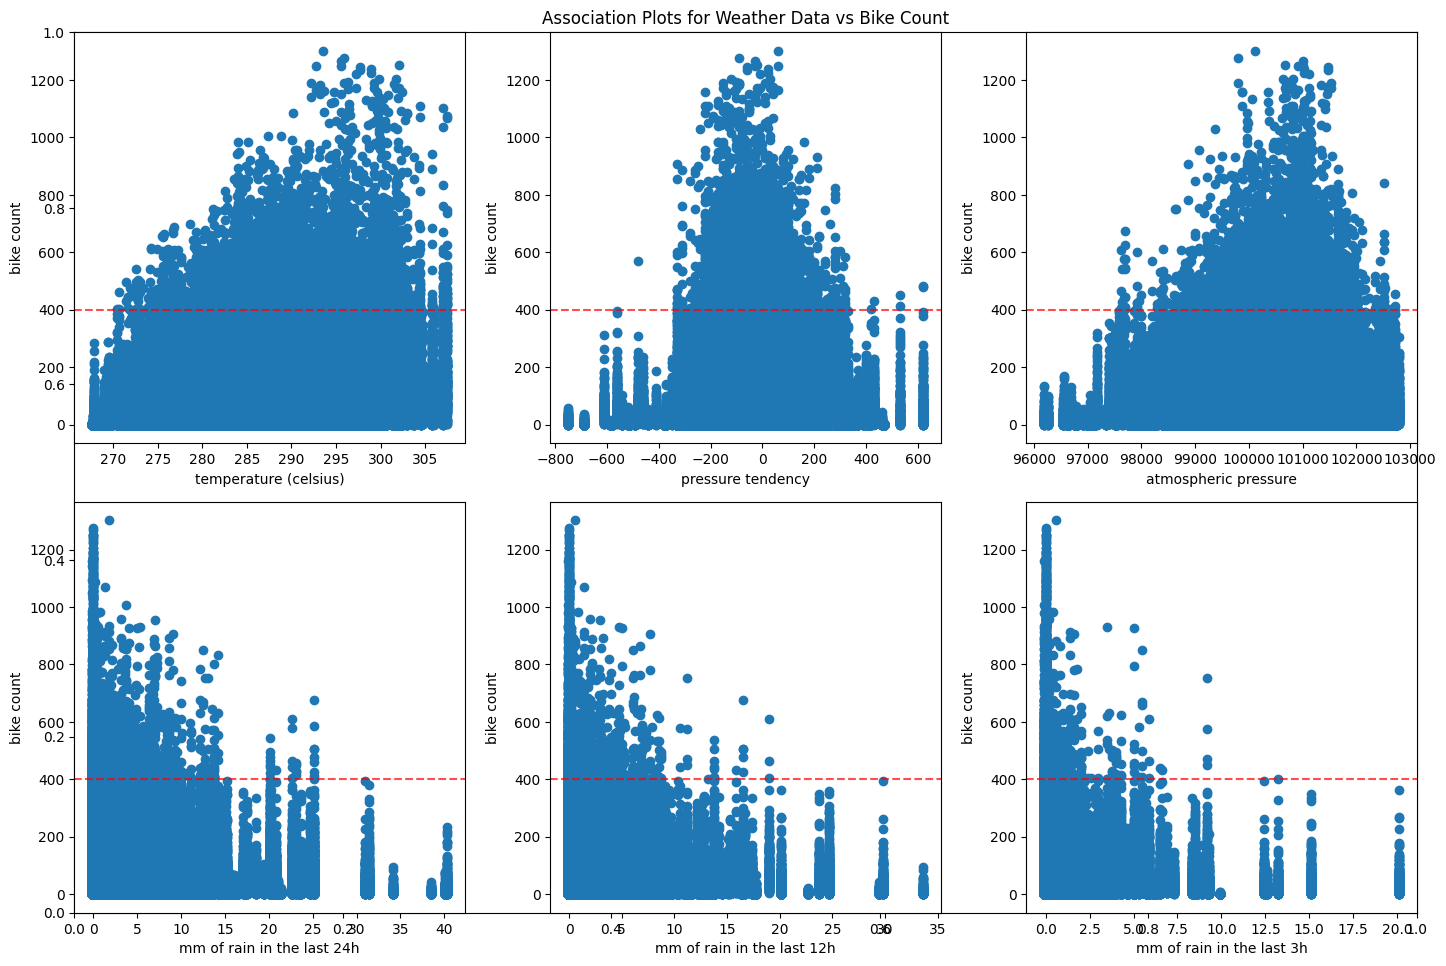

In [147]:
plt.figure(figsize=(15, 10))
plt.title("Association Plots for Weather Data vs Bike Count")

plt.subplot(2, 3, 1)
get_scatter(X["t"], "temperature (celsius)")

plt.subplot(2, 3, 2)
get_scatter(X["tend"], "pressure tendency")

plt.subplot(2, 3, 3)
get_scatter(X["pres"], "atmospheric pressure")

plt.subplot(2, 3, 4)
get_scatter(X["rr24"], "mm of rain in the last 24h")

plt.subplot(2, 3, 5)
get_scatter(X["rr12"], "mm of rain in the last 12h")

plt.subplot(2, 3, 6)
get_scatter(X["rr3"], "mm of rain in the last 3h")

plt.tight_layout()
plt.show()

On remarque une sorte de talon dans les flux de vélos. Peu importe les conditions météorologiques, une certaine partie des cyclistes continue à prendre le vélo. Surement des gens qui n'ont pas d'autre alternative simple, ou alors des gens dont leur travail se base sur l'utilisation d'un vélo (type livreur uber eats)

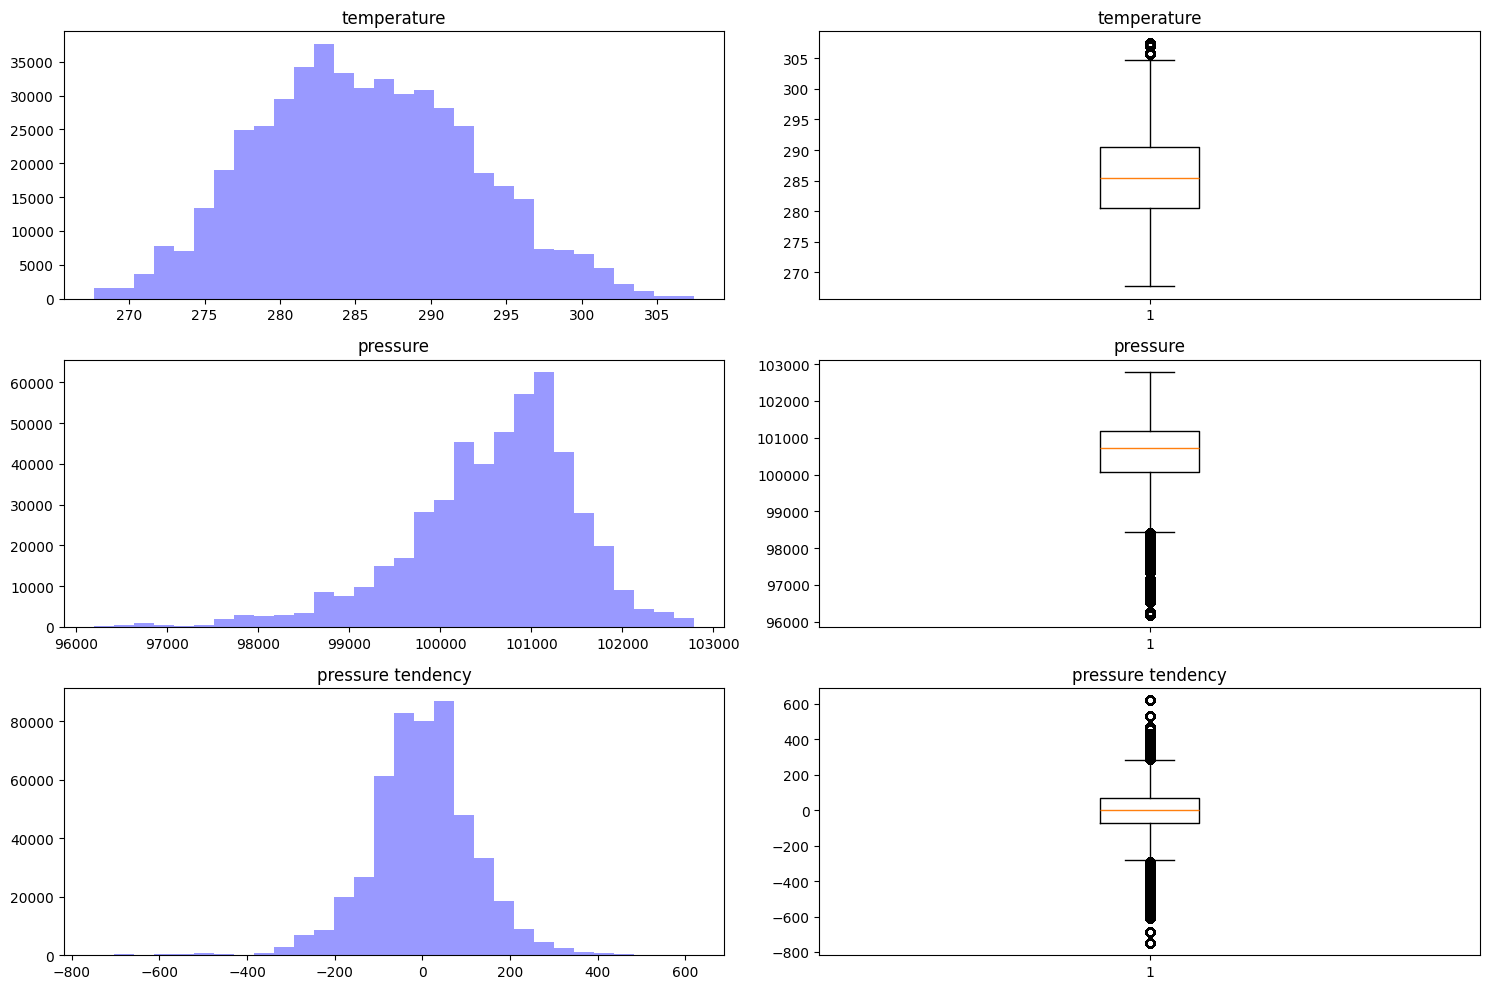

In [166]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
get_hist(X["t"], "temperature")

plt.subplot(3, 2, 2)
get_boxplot(X["t"], "temperature")

plt.subplot(3, 2, 3)
get_hist(X["pres"], "pressure")

plt.subplot(3, 2, 4)
get_boxplot(X["pres"], "pressure")

plt.subplot(3, 2, 5)
get_hist(X["tend"], "pressure tendency")

plt.subplot(3, 2, 6)
get_boxplot(X["tend"], "pressure tendency")

plt.tight_layout()
plt.show()